#Task
In this task, you will work with dummy sales data of a well-known brand on Amazon. Your objective is to build a time series forecasting model that predicts the number of units sold for each item ID.


## Load the datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
data = pd.read_csv("/content/train.csv")

#Exploratory Data Analysis (EDA)

In [3]:
# EDA for Training Dataset
print("Training Dataset")
print(data.head())
print(data.info())
print(data.describe())
print("Missing Values:\n", data.isnull().sum())

# Drop rows with missing values
data.dropna(inplace=True)

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Extract additional features from the date
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['dayofweek'] = data['date'].dt.dayofweek
data['weekofyear'] = data['date'].dt.isocalendar().week



Training Dataset
                         ID       date     Item Id  \
5261  2022-08-06_B09KSXP3HN 2022-08-06  B09KSXP3HN   
5263  2022-08-06_B09KF1P32N 2022-08-06  B09KF1P32N   
5265  2022-08-06_B09KDYY3SB 2022-08-06  B09KDYY3SB   
5266  2022-08-06_B09KDW1YKQ 2022-08-06  B09KDW1YKQ   
5267  2022-08-06_B09KDNYCYR 2022-08-06  B09KDNYCYR   

                                              Item Name  ad_spend anarix_id  \
5261       NapQueen Elsa 8" Innerspring Mattress, Queen      0.00  NAPQUEEN   
5263  NapQueen Elizabeth 12" Gel Memory Foam Mattres...     44.46  NAPQUEEN   
5265  NapQueen Elizabeth 10" Gel Memory Foam Mattres...      0.00  NAPQUEEN   
5266  NapQueen Elizabeth 8" Gel Memory Foam Mattress...      7.47  NAPQUEEN   
5267  NapQueen Elizabeth 8" Gel Memory Foam Mattress...   1187.33  NAPQUEEN   

      units  unit_price  year  month  day  dayofweek  weekofyear  
5261    1.0         0.0  2022      8    6          5          31  
5263    1.0         0.0  2022      8    6        

<ipython-input-4-f7b90c5ed20f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='month', palette='viridis')


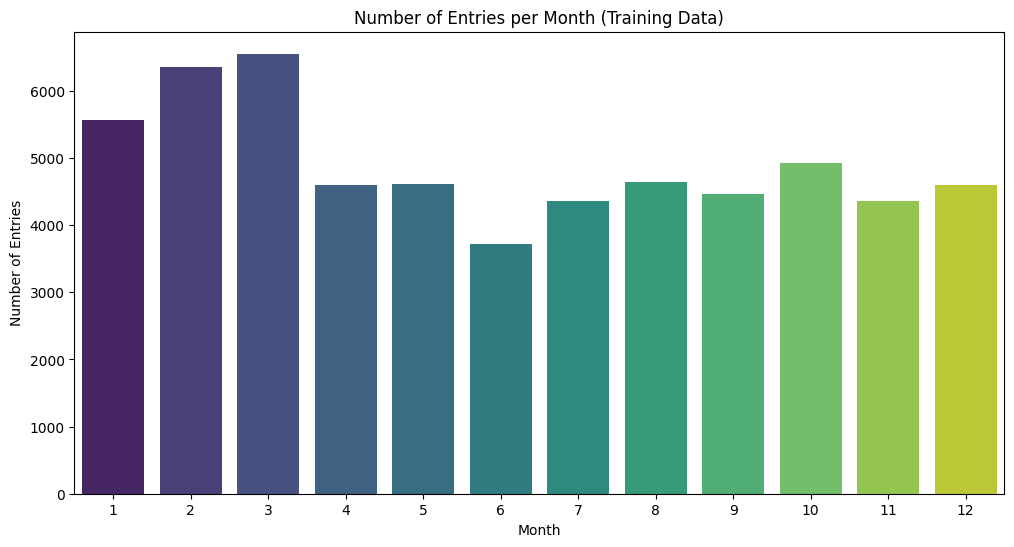

In [4]:
# Plot number of entries per month
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='month', palette='viridis')
plt.title('Number of Entries per Month (Training Data)')
plt.xlabel('Month')
plt.ylabel('Number of Entries')
plt.show()



<ipython-input-5-fffc1a6101d0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='dayofweek', palette='viridis')


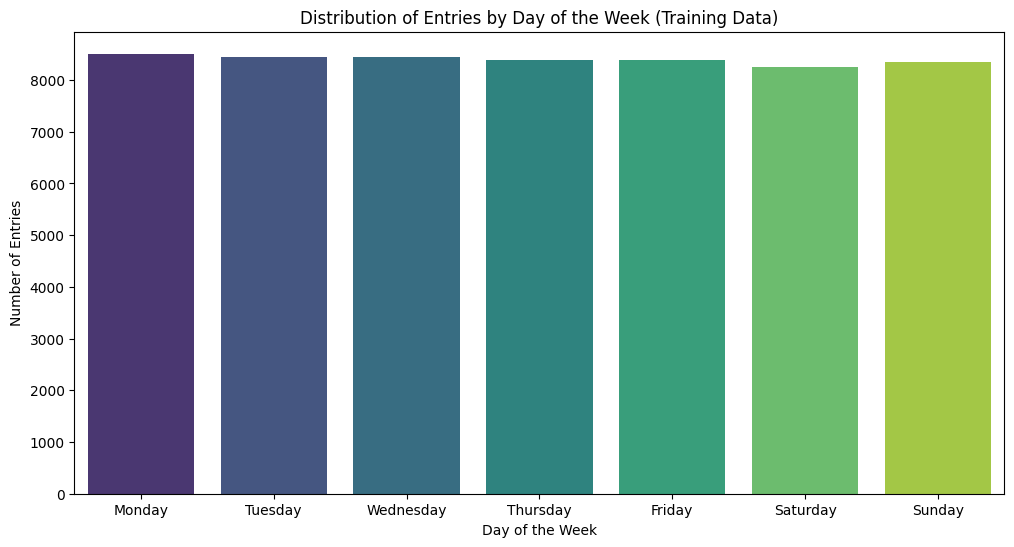

In [5]:
# Plot distribution of entries by day of the week
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='dayofweek', palette='viridis')
plt.title('Distribution of Entries by Day of the Week (Training Data)')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Entries')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

#Feature Engineering

In [6]:
# Create lag features and rolling mean features
data['units_lag_1'] = data.groupby('Item Id')['units'].shift(1)
data['units_lag_7'] = data.groupby('Item Id')['units'].shift(7)
data['units_roll_mean_7'] = data.groupby('Item Id')['units'].transform(lambda x: x.rolling(7).mean())
data['units_lag_30'] = data.groupby('Item Id')['units'].shift(30)
data['units_roll_mean_30'] = data.groupby('Item Id')['units'].transform(lambda x: x.rolling(30).mean())

# Drop rows with any missing values created by lag and rolling window operations
data.dropna(inplace=True)

# Define feature matrix X and target vector y
X = data.drop(['units', 'date', 'Item Id', 'Item Name'], axis=1)
y = data['units']


#Model Selection

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical features
categorical_features = ['ID', 'anarix_id']
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features)
    ],
    remainder='passthrough'
)

# Define and train models
models = {
    'Linear Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]),
    'Ridge Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', Ridge(alpha=1.0))
    ]),
    'Lasso Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', Lasso(alpha=0.1))
    ]),
    'Gradient Boosting Machines': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
}

# Train and evaluate models
mse_scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mse_scores[model_name] = mse
    print(f"{model_name} MSE: {mse}")

# Find the best model
best_model_name = min(mse_scores, key=mse_scores.get)
print(f"\nThe best model based on MSE is: {best_model_name} with MSE: {mse_scores[best_model_name]}")


Linear Regression MSE: 967.195947851786
Ridge Regression MSE: 967.1533279634668
Lasso Regression MSE: 942.9285037322292
Gradient Boosting Machines MSE: 516.6289504200828

The best model based on MSE is: Gradient Boosting Machines with MSE: 516.6289504200828


#Hyperparameter Tuning

In [8]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3, 5]
}

# Initialize the Gradient Boosting Regressor within a Pipeline
gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(gb_model, param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Print best hyperparameters
print("Best parameters for Gradient Boosting Machines:", grid_search.best_params_)


Best parameters for Gradient Boosting Machines: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}


#Predicting on Test Data

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer

# Load the test dataset
test = pd.read_csv('/content/test.csv')

# Convert 'date' column to datetime
test['date'] = pd.to_datetime(test['date'])

# Extract additional features from the date
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek
test['weekofyear'] = test['date'].dt.isocalendar().week

# Sort test data by 'Item Id' and 'date' to ensure proper time series operations
test = test.sort_values(by=['Item Id', 'date'])

# Create lag features and rolling mean features for the test dataset
test['units_lag_1'] = test.groupby('Item Id')['unit_price'].shift(1)
test['units_lag_7'] = test.groupby('Item Id')['unit_price'].shift(7)
test['units_lag_30'] = test.groupby('Item Id')['unit_price'].shift(30)
test['units_roll_mean_7'] = test.groupby('Item Id')['unit_price'].transform(lambda x: x.rolling(7).mean())
test['units_roll_mean_30'] = test.groupby('Item Id')['unit_price'].transform(lambda x: x.rolling(30).mean())

# Handle missing values in the test dataset created by lag and rolling window operations
test.fillna(0, inplace=True)

# Define the feature matrix for the test data
X_test = test.drop(['date', 'Item Id', 'Item Name'], axis=1)

# Define categorical and numerical features
categorical_features = ['ID', 'anarix_id']
numerical_features = X_test.select_dtypes(include=[np.number]).columns.tolist()

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features)
    ],
    remainder='passthrough'
)

# Initialize the Gradient Boosting Regressor with best hyperparameters
best_gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42))
])

# Fit the model on the training data again
best_gb_model.fit(X_train, y_train)

# Predict the target variable for the test dataset
test['TARGET'] = best_gb_model.predict(X_test)

# Create a submission file
submission = test[['date', 'Item Id', 'TARGET']]
submission.to_csv('sample_submission.csv', index=False)

print("Submission file created successfully.")


Submission file created successfully.
